In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import Experiment, CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

import numpy as np
import matplotlib.pyplot as plt

In this notebook, we extend the Galaxy Lensing notebook to include cross-correlated lensing planes. All this really requires is expanding the Fisher matrix to include these different redshift bins, and associated cross-correlations.

In [3]:
# create an Observables object to store information for derivatives
obs = Observables(parameters= ['A_s', 'omega_cdm', 'm_ncdm'],
                  fiducial=[2.1e-9, 0.12,  0.06],
                  left=[2.0e-9, 0.10, 0.0],
                  right=[2.2e-9, 0.14, 0.12])

In [11]:
# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl sCl mPk rCl',
                   'l_max_scalars': 5000,
                   'lensing': 'yes',
                   'N_ncdm': 1,
                   'non linear': 'halofit',
                   'selection': 'dirac',
                   'selection_mean': '0.5, 1.0, 1.5, 2.0, 2.5',
                   'non_diagonal': 4,
                   'l_max_lss' : 5000,
                    'accurate_lensing':1
                  }
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)
# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

The only thing in the setup that has changed is the configuration lines,
```python
'selection_mean': '0.5, 1.0, 1.5, 2.0, 2.5',
'non_diagonal': 4,
```
which asks CLASS to compute the lensing potential in five different redshift source planes, and also compute the cross-correlations so we have access to the full covariance matrix.

In [12]:
# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial', classy_dict=classy_template)

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left', classy_dict=classy_left)
    obs.compute_cosmo(key=par + '_CLASS_right', classy_dict=classy_right)

## Test Plot
First, we will examine the `density_cl()` dictionary.

In [13]:
cls_fid = obs.cosmos['CLASS_fiducial'].density_cl()

cls_fid

{'ell': array([   0,    1,    2, ..., 4998, 4999, 5000]),
 'll': {0: array([0.00000000e+00, 0.00000000e+00, 2.48396898e-09, ...,
         3.45627329e-26, 3.45290208e-26, 3.44952063e-26]),
  1: array([0.00000000e+00, 0.00000000e+00, 2.99447587e-09, ...,
         6.15133846e-26, 6.14565590e-26, 6.13995413e-26]),
  2: array([0.00000000e+00, 0.00000000e+00, 3.18908920e-09, ...,
         7.02585863e-26, 7.01942605e-26, 7.01297137e-26]),
  3: array([0.00000000e+00, 0.00000000e+00, 3.29043732e-09, ...,
         7.45574141e-26, 7.44894014e-26, 7.44211536e-26]),
  4: array([0.00000000e+00, 0.00000000e+00, 3.35257714e-09, ...,
         7.71151698e-26, 7.70449635e-26, 7.69745136e-26]),
  5: array([0.00000000e+00, 0.00000000e+00, 3.81958206e-09, ...,
         2.05087198e-25, 2.04918456e-25, 2.04749014e-25]),
  6: array([0.00000000e+00, 0.00000000e+00, 4.16813777e-09, ...,
         2.75074934e-25, 2.74853136e-25, 2.74630386e-25]),
  7: array([0.00000000e+00, 0.00000000e+00, 4.35660835e-09, ...,
   

The CLASS python wrapper documentation says this about this dictionary,

> Array that contains the list (in this order) of self correlation of
> 1st bin, then successive correlations (set by non_diagonal) to the
> following bins, then self correlation of 2nd bin, etc. The array
> starts at index_ct_dd.

It looks like this is basically the upper-triangle of the covariance matrix, written top-to-bottom and left-to-right. We'll write a $\mathbf{C}_{\ell}$ matrix utility to extract this matrix from the dictionary.

In [96]:
def get_kcov(cosmo, nbins, non_diagonal, verbose=False):
    """
    Generate a WL convergence covariance matrix from a CLASS dictionary.
    
    There's a for loop in here, but this function gets run once per CLASS
    call, so I think the performance of the function doesn't really matter.
    
    Parameters
    ----------
        cosmo (CLASS wrapper object) : stored, computed cosmology
        nbins (integer) : number of redshift bins
        non_diagonal (integer) number of non-diagonal bins
    """
    dcl = cosmo.density_cl()
    ell = dcl['ell']
    pref = 0.25 * (ell+2) * (ell+1) * (ell) * (ell-1)
    cov_mat = np.zeros((nbins, nbins, len(ell)))
    debug_mat = np.zeros((nbins, nbins))
    counter = 0
    for bin_index in range(nbins):
        for diag_index in range(min(nbins-bin_index, non_diagonal+1)):
            debug_mat[bin_index, bin_index+diag_index] = counter
            debug_mat[bin_index+diag_index, bin_index] = counter
            
            # we multiply the prefactors to use the lensing convergence instead 
            # of the lensing potential
            cov_mat[bin_index, bin_index+diag_index, :] = pref * dcl['ll'][counter]
            cov_mat[bin_index+diag_index, bin_index, :] = pref * dcl['ll'][counter]
            
            counter += 1
    
    # if verbose is set, we produce a matrix which refers to the CLASS 
    # cosmo index, for each array cross section.
    if(verbose):
        print('debug matrix:\n', debug_mat)
    return cov_mat

example_kcov = get_kcov(obs.cosmos['CLASS_fiducial'], nbins=5, non_diagonal=4, verbose=True)

debug matrix:
 [[ 0.  1.  2.  3.  4.]
 [ 1.  5.  6.  7.  8.]
 [ 2.  6.  9. 10. 11.]
 [ 3.  7. 10. 12. 13.]
 [ 4.  8. 11. 13. 14.]]


We'll plot just the fiducial $P_{\kappa}$ for this notebook, showing the different signal curves for each redshift.

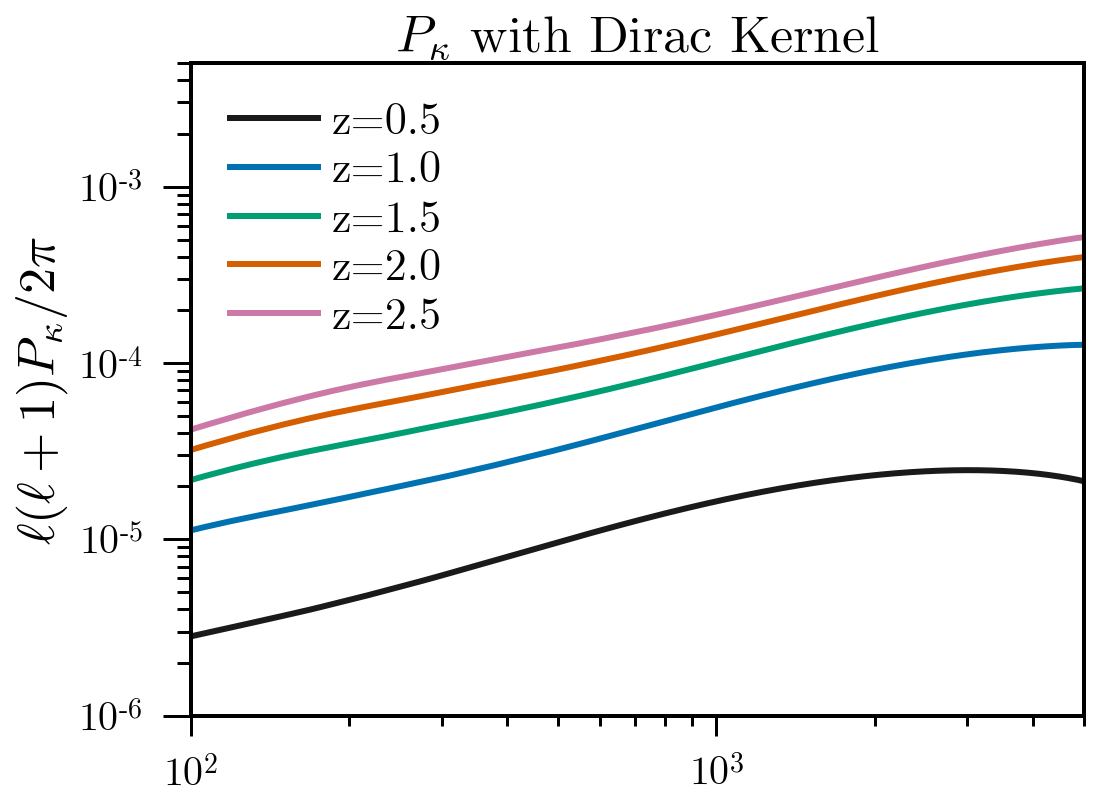

In [100]:
plt.figure(figsize=(8,6))

ell = np.arange(5000+1)

pref2 = ell * (ell+1) / (2. * np.pi)

for i, z in enumerate([0.5, 1.0, 1.5, 2.0, 2.5]):
    plt.plot( ell, pref2*example_kcov[i,i,:] , '-', label='z=' + str(z) )


plt.yscale('log')
plt.xscale('log')
plt.xlim(1e2,5e3)

plt.ylabel(r'$\ell (\ell+1) P_{\kappa} / 2 \pi$')
plt.ylim(1e-6,5e-3)
plt.legend()
plt.title('$P_{\kappa}$ with Dirac Kernel');

## Write an Experiment Class
We basically copy and paste the experiment class from the Galaxy Lensing notebook, but this time we include different redshift bins by expanding the covariance matrix. As stated in the Galaxy Lensing notebook, we have (Kaiser 1992, 1998, Hu 1999) for redshift bins $i,j$,

$$ C_{ij}(\ell) = P^{\kappa}_{ij}(\ell) + \delta_{ij} \frac{\sigma_e^2}{\bar{n}_i}$$

Then

$$F_{\alpha \beta} = \sum_{\ell=2}^{\ell_{max}} (\ell + 1/2) f_{sky} \mathrm{tr} \left[ \mathbf{C}^{-1} \mathbf{C}_{,\alpha} \mathbf{C}^{-1} \mathbf{C}_{,\beta} \right]$$